# Develop a model to predict an individuals' credit score, given a feature set

#### Use the provided bank loan data to develop a model that can predict an individuals credit score, and then interpret the results to find the variables that are most predictive of the score.

This is a supervised, regression machine learning problem: given a set of data(x) with targets(y) (in this case the credit score) included, we want to train a model that can learn to map the features (also known as the explanatory variables) to the target.

- Supervised problem: we are given both the features and the target
- Regression problem: the target is a continous variable (credit score is a number between 0-800)

## Machine Learning Workflow
### Although the exact implementation details can vary, the general structure of a machine learning project stays relatively constant:

- Data cleaning and formatting
- Exploratory data analysis
- Feature engineering and selection
- Establish a baseline and compare several machine learning models on a performance metric
- Perform hyperparameter tuning on the best model to optimize it for the problem
- Evaluate the best model on the testing set
- Interpret the model results to the extent possible
- Draw conclusions and write a well-documented report

#### This is not a linear workflow, as in sequence is not always maintained in the pipeline. 
#### A step can be visited more than once based on evaluation further down the pipeline. It is an iterative process

In [1]:
##### # Imports

# Pandas and numpy for data manipulation
import pandas as pd
import numpy as np
from random import randint

# No warnings about setting value on copy of slice
pd.options.mode.chained_assignment = None

# Display up to 60 columns of a dataframe
pd.set_option('display.max_columns', 60)

# Matplotlib visualization
import matplotlib.pyplot as plt
%matplotlib inline

# Set default font size
plt.rcParams['font.size'] = 24

# Internal ipython tool for setting figure size
from IPython.core.pylabtools import figsize

# Seaborn for visualization
import seaborn as sns
sns.set(font_scale = 2)

# Splitting data into training and testing
from sklearn.model_selection import train_test_split

## Cleaning Data and Formatting

### Load Data and Examine

In [2]:
raw_df = pd.read_csv('credit_train.csv') #read training data

In [3]:
raw_df.head() #Take a look at the data

,Loan ID,Customer ID,LoanStatus,CurrentLoanAmount,Term,Credit Score,Annual Income,Years in current job,Home Ownership,Purpose,Monthly Debt,Years of Credit History,Months since last delinquent,Number of Open Accounts,Number of Credit Problems,Current Credit Balance,Maximum Open Credit,Bankruptcies,Tax Liens
0,14dd8831-6af5-400b-83ec-68e61888a048,981165ec-3274-42f5-a3b4-d104041a9ca9,Fully Paid,445412,Short Term,709.0,1167493.0,8 years,Home Mortgage,Home Improvements,5214.74,17.2,NaN,6,1,228190,416746.0,1.0,0.0
1,4771cc26-131a-45db-b5aa-537ea4ba5342,2de017a3-2e01-49cb-a581-08169e83be29,Fully Paid,262328,Short Term,NaN,NaN,10+ years,Home Mortgage,Debt Consolidation,33295.98,21.1,8.0,35,0,229976,850784.0,0.0,0.0
2,4eed4e6a-aa2f-4c91-8651-ce984ee8fb26,5efb2b2b-bf11-4dfd-a572-3761a2694725,Fully Paid,99999999,Short Term,741.0,2231892.0,8 years,Own Home,Debt Consolidation,29200.53,14.9,29.0,18,1,297996,750090.0,0.0,0.0
3,77598f7b-32e7-4e3b-a6e5-06ba0d98fe8a,e777faab-98ae-45af-9a86-7ce5b33b1011,Fully Paid,347666,Long Term,721.0,806949.0,3 years,Own Home,Debt Consolidation,8741.90,12.0,NaN,9,0,256329,386958.0,0.0,0.0
4,d4062e70-befa-4995-8643-a0de73938182,81536ad9-5ccf-4eb8-befb-47a4d608658e,Fully Paid,176220,Short Term,NaN,NaN,5 years,Rent,Debt Consolidation,20639.70,6.1,NaN,15,0,253460,427174.0,0.0,0.0


#### Count of data in each Column

In [4]:
raw_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100000 entries, 0 to 99999
Data columns (total 19 columns):
Loan ID                         100000 non-null object
Customer ID                     100000 non-null object
LoanStatus                      100000 non-null object
CurrentLoanAmount               100000 non-null int64
Term                            100000 non-null object
Credit Score                    80846 non-null float64
Annual Income                   80846 non-null float64
Years in current job            95778 non-null object
Home Ownership                  100000 non-null object
Purpose                         100000 non-null object
Monthly Debt                    100000 non-null float64
Years of Credit History         100000 non-null float64
Months since last delinquent    46859 non-null float64
Number of Open Accounts         100000 non-null int64
Number of Credit Problems       100000 non-null int64
Current Credit Balance          100000 non-null int64
Maximum Open 

In [5]:
## Drop Loan ID and Customer ID as they are for identification purpose only
raw_df.drop(labels=['Loan ID', 'Customer ID'], axis=1, inplace=True)

### Need to Figure out percentage of missing data in each column

#### Following is a function that calculates the number of missing values and the percentage of the total values that are missing for each column. As with many tasks in data science, I did not write this function myself, but rather found it online in a [Stack Overflow Forum](https://stackoverflow.com/a/39734251)

In [6]:
# # Missing Values

# Function to calculate missing values by column
def missing_values_table(df):
    
        # Total missing values
        mis_val = df.isnull().sum()
        
        # Percentage of missing values
        mis_val_percent = 100 * df.isnull().sum() / len(df)
        
        # Make a table with the results
        mis_val_table = pd.concat([mis_val, mis_val_percent], axis=1)
        
        # Rename the columns
        mis_val_table_ren_columns = mis_val_table.rename(
        columns = {0 : 'Missing Values', 1 : '% of Total Values'})
        
        # Sort the table by percentage of missing descending
        mis_val_table_ren_columns = mis_val_table_ren_columns[
            mis_val_table_ren_columns.iloc[:,1] != 0].sort_values(
        '% of Total Values', ascending=False).round(1)
        
        # Print some summary information
        print ("Your selected dataframe has " + str(df.shape[1]) + " columns.\n"      
            "There are " + str(mis_val_table_ren_columns.shape[0]) +
              " columns that have missing values.")
        
        # Return the dataframe with missing information
        return mis_val_table_ren_columns

In [7]:
 missing_values_table(raw_df)

Your selected dataframe has 17 columns.
There are 7 columns that have missing values.


,Missing Values,% of Total Values
Months since last delinquent,53141,53.1
Credit Score,19154,19.2
Annual Income,19154,19.2
Years in current job,4222,4.2
Bankruptcies,204,0.2
Tax Liens,10,0.0
Maximum Open Credit,2,0.0


### It can be seen that Months since last delinquent has missing values > 50% 
#### Should be dropped
### Also the last 10 columns have same number of missing data

In [8]:
raw_df.drop(columns = 'Months since last delinquent', axis=1, inplace=True)

In [9]:
raw_df.shape

(100000, 16)

In [10]:
raw_df[raw_df['Monthly Debt'].isnull() == True]

,LoanStatus,CurrentLoanAmount,Term,Credit Score,Annual Income,Years in current job,Home Ownership,Purpose,Monthly Debt,Years of Credit History,Number of Open Accounts,Number of Credit Problems,Current Credit Balance,Maximum Open Credit,Bankruptcies,Tax Liens


In [11]:
### Last 514 rows are all NaN so drop them
raw_df.drop(raw_df.tail(514).index, inplace=True) # drop last 514 rows

In [12]:
## Check Missing values now
missing_values_table(raw_df)

Your selected dataframe has 16 columns.
There are 6 columns that have missing values.


,Missing Values,% of Total Values
Credit Score,19056,19.2
Annual Income,19056,19.2
Years in current job,4195,4.2
Bankruptcies,203,0.2
Tax Liens,10,0.0
Maximum Open Credit,2,0.0


In [13]:
# As the number of missing values is so low in the 'Maximum Open Credit' I will drop them.

for i in raw_df['Maximum Open Credit'][raw_df['Maximum Open Credit'].isnull() == True].index:
    raw_df.drop(labels=i, inplace=True)
missing_values_table(raw_df)

Your selected dataframe has 16 columns.
There are 5 columns that have missing values.


,Missing Values,% of Total Values
Credit Score,19055,19.2
Annual Income,19055,19.2
Years in current job,4195,4.2
Bankruptcies,203,0.2
Tax Liens,10,0.0


In [14]:
# As the number of missing values is so low in the 'Tax Liens' I will drop them.

for i in raw_df['Tax Liens'][raw_df['Tax Liens'].isnull() == True].index:
    raw_df.drop(labels=i, inplace=True)
missing_values_table(raw_df)

Your selected dataframe has 16 columns.
There are 4 columns that have missing values.


,Missing Values,% of Total Values
Credit Score,19051,19.2
Annual Income,19051,19.2
Years in current job,4195,4.2
Bankruptcies,193,0.2


In [15]:
# As the number of missing values is so low in the 'Bankruptcies' I will drop them.

for i in raw_df['Bankruptcies'][raw_df['Bankruptcies'].isnull() == True].index:
    raw_df.drop(labels=i, inplace=True)
missing_values_table(raw_df)

Your selected dataframe has 16 columns.
There are 3 columns that have missing values.


,Missing Values,% of Total Values
Credit Score,19013,19.2
Annual Income,19013,19.2
Years in current job,4195,4.2


In [16]:
raw_df.shape

(99281, 16)

### Take a closer look at Credit Score

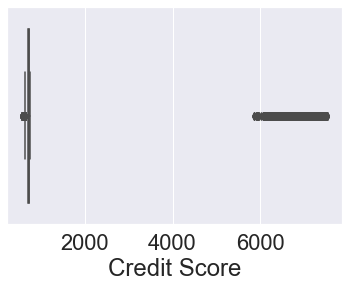

In [17]:
sns.boxplot(raw_df['Credit Score'])

#### It seems as if some of the scores are scaled up by 10

In [18]:
print(raw_df['Credit Score'].max())
print(raw_df['Credit Score'].min())
raw_df[raw_df['Credit Score'] > 800].shape

7510.0
585.0


(4527, 16)

In [19]:
### Scale down scores above 800
raw_df['Credit Score'] = raw_df['Credit Score'].apply(lambda val: (val /10) if val>800 else val)

In [20]:
print(raw_df['Credit Score'].max())
print(raw_df['Credit Score'].min())

751.0
585.0


In [21]:
# Now I will use the 'mean' technique to fill the NaN values.

raw_df['Credit Score'].fillna(raw_df['Credit Score'].mean(), inplace=True)
raw_df['Annual Income'].fillna(raw_df['Annual Income'].mean(), inplace=True)
missing_values_table(raw_df)

# The feature 'Years in current job' won't fill because it has categorical values.

Your selected dataframe has 16 columns.
There are 1 columns that have missing values.


,Missing Values,% of Total Values
Years in current job,4195,4.2


### Take a closer look at years in current job

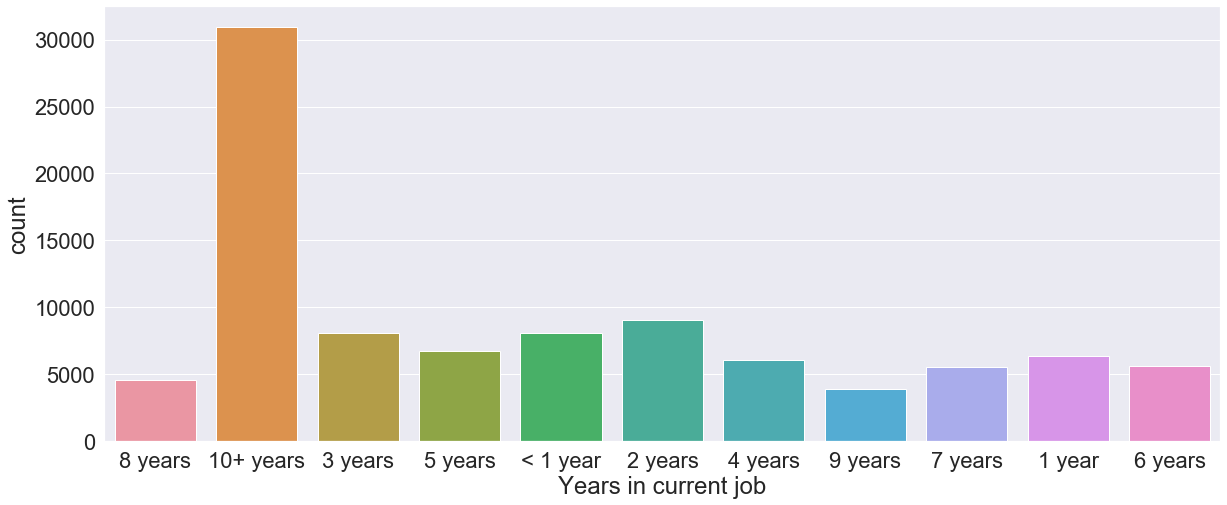

In [22]:
plt.figure(figsize=(20,8))
sns.countplot(raw_df['Years in current job'])

In [23]:
# Take the different categories in array
indexes = np.array(['8 years', '10+ years', '3 years', '5 years', '< 1 year',
           '2 years', '4 years', '9 years', '7 years', '1 year', '6 years'])

In [24]:
# randomly insert categories in the missing values

for i in raw_df['Years in current job'][raw_df['Years in current job'].isnull() == True].index:
    raw_df['Years in current job'][i] = indexes[randint(0, indexes.size -1)]
    
missing_values_table(raw_df)

Your selected dataframe has 16 columns.
There are 0 columns that have missing values.


,Missing Values,% of Total Values


#### The dataframe has zero missing values now !

## Exploratory Data Analysis

### Single variable plots

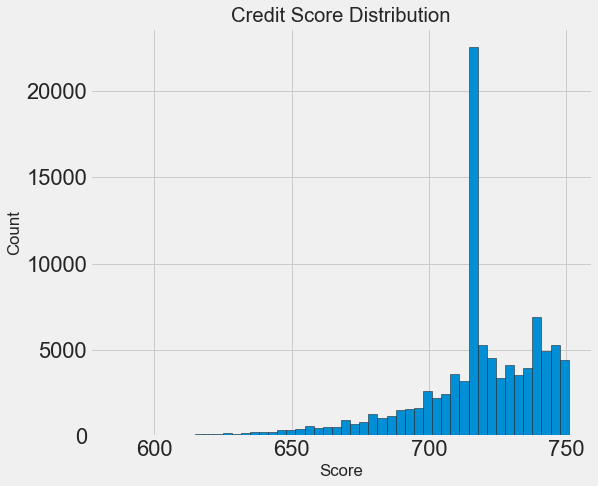

In [25]:
figsize(8, 7)

# Histogram of the Credit Score
plt.style.use('fivethirtyeight')
plt.hist(raw_df['Credit Score'], bins = 50, edgecolor = 'k');
plt.xlabel('Score'); plt.ylabel('Count'); 
plt.title('Credit Score Distribution');

#### Seems like a suspicously large percentage of people with credit score around 720, have to look into this later

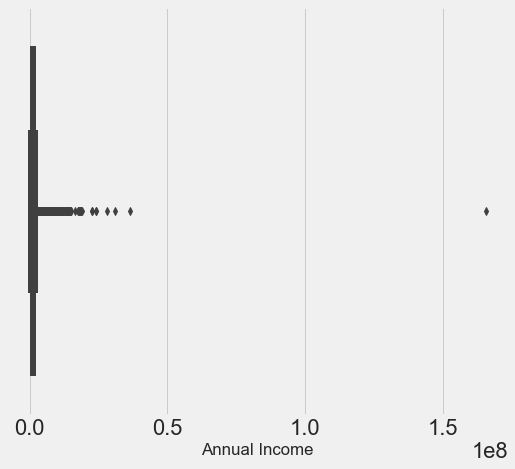

In [26]:
figsize = (6,6)
sns.boxplot(raw_df['Annual Income'])

#### Seems like outliers

In [27]:
raw_df[raw_df['Annual Income'] > 1e+08]
## This is a outlier as Loan Status is charged off, maybe a mistyping in the annual income

,LoanStatus,CurrentLoanAmount,Term,Credit Score,Annual Income,Years in current job,Home Ownership,Purpose,Monthly Debt,Years of Credit History,Number of Open Accounts,Number of Credit Problems,Current Credit Balance,Maximum Open Credit,Bankruptcies,Tax Liens
85662,Charged Off,176132,Short Term,725.0,165557393.0,10+ years,Home Mortgage,Debt Consolidation,15176.06,16.0,11,0,312778,669438.0,0.0,0.0


In [28]:
raw_df.drop(index=85662,inplace=True)

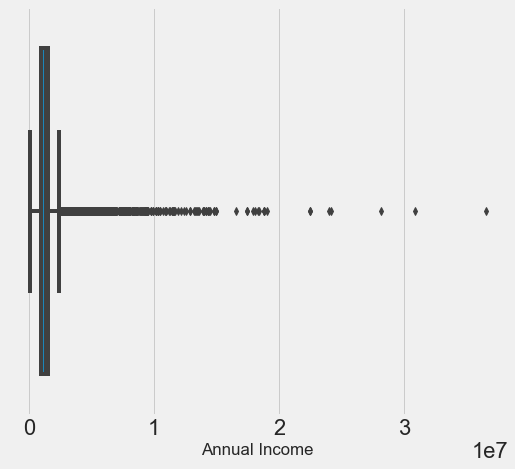

In [29]:
sns.boxplot(raw_df['Annual Income'])

In [30]:
raw_df['Credit Score'].mean()

716.27778128423

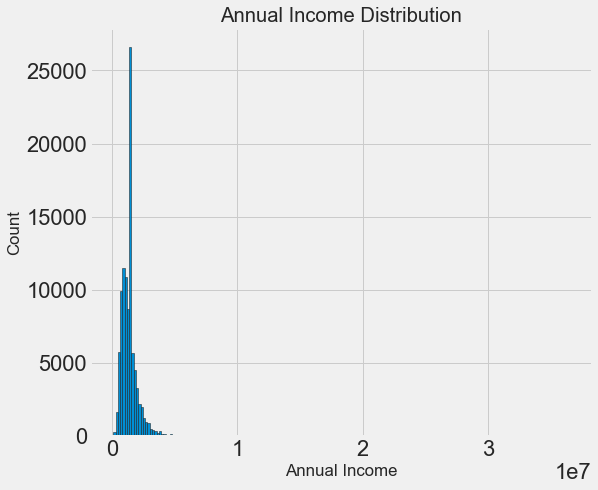

In [31]:
figsize=(8, 7)

# Histogram of the Credit Score
plt.style.use('fivethirtyeight')
plt.hist(raw_df['Annual Income'], bins = 200, edgecolor = 'k');
plt.xlabel('Annual Income'); plt.ylabel('Count'); 
plt.title('Annual Income Distribution');

#### Distribution is still very skewed 

In [32]:
raw_df[raw_df['Annual Income'] > 1e+07]
# For now keep them like this, it can be observed that most of it is for the Purpose of Debt Consolidation

,LoanStatus,CurrentLoanAmount,Term,Credit Score,Annual Income,Years in current job,Home Ownership,Purpose,Monthly Debt,Years of Credit History,Number of Open Accounts,Number of Credit Problems,Current Credit Balance,Maximum Open Credit,Bankruptcies,Tax Liens
10721,Charged Off,757460,Long Term,739.0,30838995.0,< 1 year,Home Mortgage,Debt Consolidation,50113.45,14.7,15,0,499035,1532696.0,0.0,0.0
11522,Fully Paid,334356,Short Term,743.0,14438100.0,10+ years,Home Mortgage,Home Improvements,43795.57,17.7,10,0,3387529,5140740.0,0.0,0.0
11830,Fully Paid,784014,Short Term,706.0,12574770.0,10+ years,Rent,major_purchase,31646.40,16.9,16,0,69825,594440.0,0.0,0.0
12617,Fully Paid,463210,Short Term,724.0,14287050.0,10+ years,Home Mortgage,Debt Consolidation,43456.42,22.5,12,0,1234050,7403682.0,0.0,0.0
13643,Fully Paid,99999999,Long Term,617.0,14118007.0,10+ years,Home Mortgage,Debt Consolidation,63531.06,22.5,18,0,1224702,2017180.0,0.0,0.0
16028,Charged Off,521510,Short Term,653.0,11259780.0,4 years,Own Home,Other,66526.60,23.3,9,0,1092614,3243922.0,0.0,0.0
17561,Fully Paid,215644,Short Term,741.0,17400903.0,1 year,Rent,Debt Consolidation,24796.33,13.9,27,0,236569,399894.0,0.0,0.0
17803,Fully Paid,787952,Short Term,746.0,10499058.0,10+ years,Home Mortgage,other,78043.07,26.0,12,0,719169,1826132.0,0.0,0.0
20696,Fully Paid,99999999,Short Term,735.0,18743937.0,10+ years,Home Mortgage,Debt Consolidation,28584.55,25.0,17,0,501733,1115048.0,0.0,0.0
21598,Charged Off,753214,Short Term,745.0,24161540.0,5 years,Own Home,Debt Consolidation,15503.81,28.1,22,0,183635,1214972.0,0.0,0.0


In [33]:
### Check if Current Loan amount = 99999999 causes weird credit scores
raw_df[raw_df['CurrentLoanAmount'] > 0.2e+08]['Credit Score'].describe()


count    11393.000000
mean       725.779163
std         24.701988
min        587.000000
25%        717.000000
50%        734.000000
75%        743.000000
max        751.000000
Name: Credit Score, dtype: float64

## Examining relationships between Categorical features


Looking for Relationships
In order to look at the effect of categorical variables on the score, we can make a density plot colored by the value of the categorical variable. Density plots also show the distribution of a single variable and can be thought of as a smoothed histogram. If we color the density curves by a categorical variable, this will shows us how the distribution changes based on the class.
 [Taken Reference from](https://github.com/WillKoehrsen/machine-learning-project-walkthrough/blob/master/Machine%20Learning%20Project%20Part%201.ipynb)

In [34]:
# Create a list of Purposes with more than 100 measurements to avoid clutter
types = raw_df
types = types['Purpose'].value_counts()
types = list(types[types.values > 100].index)

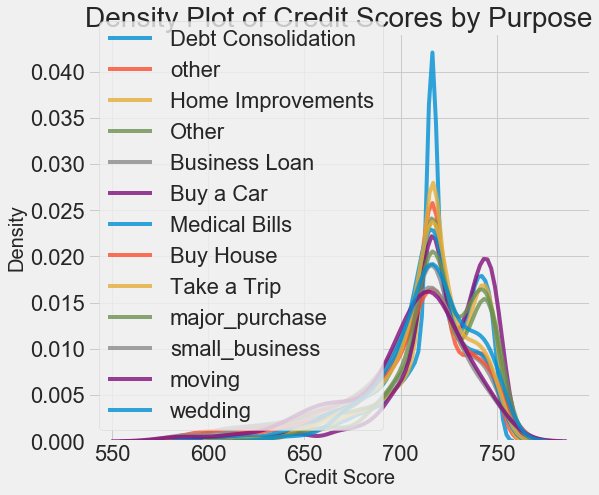

In [35]:
# Plot of distribution of Scores for each Purpose
figsize= (10, 8)

# Plot each Purpose
for b_type in types:
    # Select the Purpose type
    subset = raw_df[raw_df['Purpose'] == b_type]
    
    # Density plot of scores
    sns.kdeplot(subset['Credit Score'],
               label = b_type, shade = False, alpha = 0.8);
    
# label the plot
plt.xlabel('Credit Score', size = 20); plt.ylabel('Density', size = 20); 
plt.title('Density Plot of Credit Scores by Purpose', size = 28);

### The type of Purpose doesn't have significant impact on distribution

In [36]:
# Create a list of Home OwnerShip with more than 100 measurements to avoid clutter
types = raw_df
types = types['Home Ownership'].value_counts()
types = list(types[types.values > 100].index)

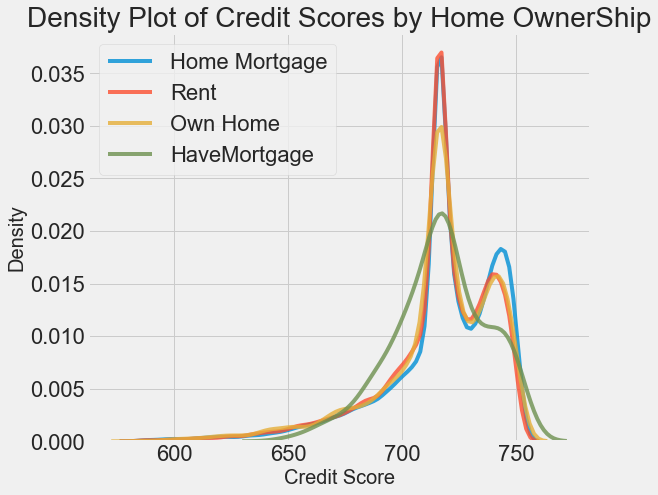

In [37]:
# Plot of distribution of Scores for each Home Ownership
figsize= (12, 10)

# Plot each Purpose
for b_type in types:
    # Select the HomeOwnership type
    subset = raw_df[raw_df['Home Ownership'] == b_type]
    
    # Density plot of scores
    sns.kdeplot(subset['Credit Score'],
               label = b_type, shade = False, alpha = 0.8);
    
# label the plot
plt.xlabel('Credit Score', size = 20); plt.ylabel('Density', size = 20); 
plt.title('Density Plot of Credit Scores by Home OwnerShip', size = 28);

### The type of Home Ownership has slight impact on distribution

In [38]:
# Create a list of Term with more than 100 measurements to avoid clutter
types = raw_df
types = types['Term'].value_counts()
types = list(types[types.values > 100].index)

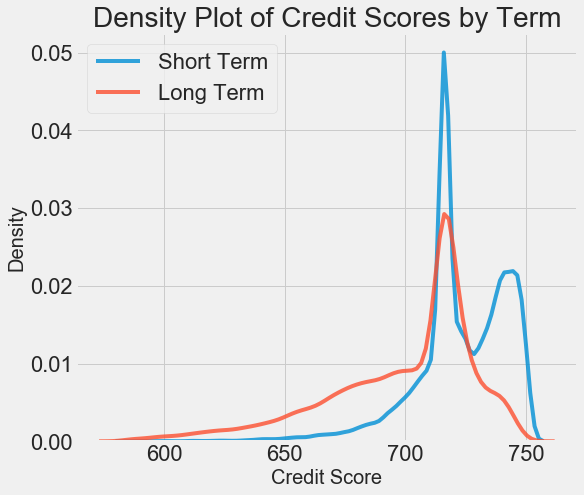

In [39]:
# Plot of distribution of Scores for each Term
figsize=(12, 10)

# Plot each Term
for b_type in types:
    # Select the Term type
    subset = raw_df[raw_df['Term'] == b_type]
    
    # Density plot of scores
    sns.kdeplot(subset['Credit Score'],
               label = b_type, shade = False, alpha = 0.8);
    
# label the plot
plt.xlabel('Credit Score', size = 20); plt.ylabel('Density', size = 20); 
plt.title('Density Plot of Credit Scores by Term', size = 28);

In [40]:
# Create a list of Years in job with more than 100 measurements to avoid clutter
types = raw_df
types = types['Years in current job'].value_counts()
types = list(types[types.values > 100].index)

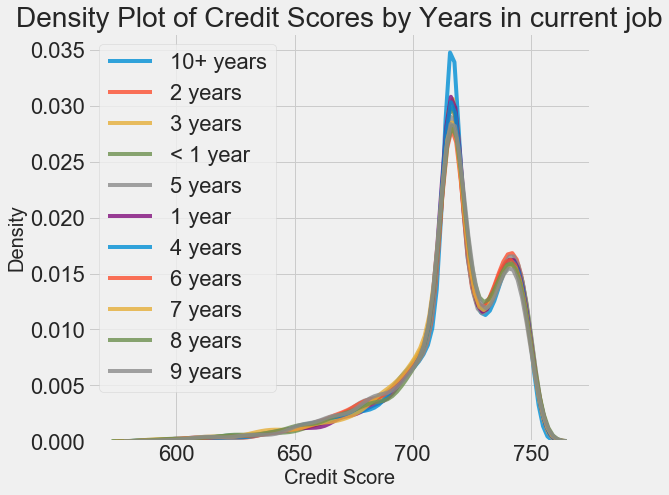

In [41]:
# Plot of distribution of Scores for each category
figsize=(12, 10)

# Plot each category
for b_type in types:
    # Select the category type
    subset = raw_df[raw_df['Years in current job'] == b_type]
    
    # Density plot of scores
    sns.kdeplot(subset['Credit Score'],
               label = b_type, shade = False, alpha = 0.8);
    
# label the plot
plt.xlabel('Credit Score', size = 20); plt.ylabel('Density', size = 20); 
plt.title('Density Plot of Credit Scores by Years in current job', size = 28);

### Doesn't have any impact on distribution, would be okay to not include it 

## Correlations between Features and Target ¶
#### In order to quantify correlations between the features (variables) and the target, we can calculate the Pearson correlation coefficient. This is a measure of the strength and direction of a linear relationship between two variables: a value of -1 means the two variables are perfectly negatively linearly correlated and a value of +1 means the two variables are perfectly positively linearly correlated. The figure below shows different values of the correlation coeffient and how they appear graphically.

![title](img/correlation_examples.png)

In [42]:
# Find all correlations and sort 
correlations_data = raw_df.corr()['Credit Score'].sort_values()

# Print the Correlations
print(correlations_data)

Monthly Debt                -0.082393
Number of Credit Problems   -0.043030
Bankruptcies                -0.031572
Number of Open Accounts     -0.026807
Tax Liens                   -0.018709
Current Credit Balance      -0.014772
Annual Income               -0.006817
Maximum Open Credit          0.012851
Years of Credit History      0.069737
CurrentLoanAmount            0.133407
Credit Score                 1.000000
Name: Credit Score, dtype: float64


To account for possible non-linear relationships, we can take square root and natural log transformations of the features and then calculate the correlation coefficients with the score. To try and capture any possible relationships between the borough or building type (remember these are categorical variables) and the score we will have to one-hot encode these columns.

In the following code, we take log and square root transformations of the numerical variables, one-hot encode the two selected categorical variables (building type and borough), calculate the correlations between all of the features and the score, and display the top 15 most positive and top 15 most negative correlations. This is a lot, but with pandas, it is straightforward to do each step!


In [43]:
raw_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 99280 entries, 0 to 99485
Data columns (total 16 columns):
LoanStatus                   99280 non-null object
CurrentLoanAmount            99280 non-null int64
Term                         99280 non-null object
Credit Score                 99280 non-null float64
Annual Income                99280 non-null float64
Years in current job         99280 non-null object
Home Ownership               99280 non-null object
Purpose                      99280 non-null object
Monthly Debt                 99280 non-null float64
Years of Credit History      99280 non-null float64
Number of Open Accounts      99280 non-null int64
Number of Credit Problems    99280 non-null int64
Current Credit Balance       99280 non-null int64
Maximum Open Credit          99280 non-null float64
Bankruptcies                 99280 non-null float64
Tax Liens                    99280 non-null float64
dtypes: float64(7), int64(4), object(5)
memory usage: 12.9+ MB


## Create columns with square root and log of Numeric columns
### Normalising

In [44]:

# Select the numeric columns
numeric_subset = raw_df.select_dtypes('number')

# Create columns with square root and log of numeric columns
for col in numeric_subset.columns:
    # Skip the Credit Score column
    if col == 'Credit Score':
        next
    else:
        numeric_subset['sqrt_' + col] = np.sqrt(numeric_subset[col])
        numeric_subset['log_' + col] = np.log(numeric_subset[col])

# Select the categorical columns
categorical_subset = raw_df[['LoanStatus', 'Term', 'Years in current job', 'Home Ownership', 'Purpose']]

# One hot encode
categorical_subset = pd.get_dummies(categorical_subset)

# Join the two dataframes using concat
# Make sure to use axis = 1 to perform a column bind
features = pd.concat([numeric_subset, categorical_subset], axis = 1)

# Find correlations with the score 
correlations = features.corr()['Credit Score'].dropna().sort_values()

C:\ProgramData\Anaconda3\envs\fastai_v1\lib\site-packages\ipykernel_launcher.py:11: RuntimeWarning: divide by zero encountered in log
  # This is added back by InteractiveShellApp.init_path()


In [45]:
# Display most negative correlations
correlations.head(15)

Term_Long Term                   -0.421790
LoanStatus_Charged Off           -0.095387
sqrt_Monthly Debt                -0.084835
Monthly Debt                     -0.082393
Purpose_other                    -0.080583
log_Monthly Debt                 -0.077487
Purpose_Business Loan            -0.060584
sqrt_Number of Credit Problems   -0.045119
Number of Credit Problems        -0.043030
Purpose_Buy House                -0.039684
log_Number of Credit Problems    -0.033488
Home Ownership_Rent              -0.032702
Bankruptcies                     -0.031572
sqrt_Bankruptcies                -0.031226
Purpose_small_business           -0.030636
Name: Credit Score, dtype: float64

In [46]:
# Display most positive correlations
correlations.tail(15)

Maximum Open Credit             0.012851
Purpose_Buy a Car               0.027473
Home Ownership_Home Mortgage    0.037987
Years of Credit History         0.069737
sqrt_Years of Credit History    0.073349
Purpose_Debt Consolidation      0.074987
log_Years of Credit History     0.076036
log_CurrentLoanAmount           0.079511
sqrt_Maximum Open Credit        0.080289
LoanStatus_Fully Paid           0.095387
log_Maximum Open Credit         0.108423
sqrt_CurrentLoanAmount          0.125221
CurrentLoanAmount               0.133407
Term_Short Term                 0.421790
Credit Score                    1.000000
Name: Credit Score, dtype: float64

### It is seen that Current Loan amount,Term has strong correlation, lets plot scatter plot of to see its effect

In [47]:
features.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 99280 entries, 0 to 99485
Data columns (total 66 columns):
CurrentLoanAmount                 99280 non-null int64
Credit Score                      99280 non-null float64
Annual Income                     99280 non-null float64
Monthly Debt                      99280 non-null float64
Years of Credit History           99280 non-null float64
Number of Open Accounts           99280 non-null int64
Number of Credit Problems         99280 non-null int64
Current Credit Balance            99280 non-null int64
Maximum Open Credit               99280 non-null float64
Bankruptcies                      99280 non-null float64
Tax Liens                         99280 non-null float64
sqrt_CurrentLoanAmount            99280 non-null float64
log_CurrentLoanAmount             99280 non-null float64
sqrt_Annual Income                99280 non-null float64
log_Annual Income                 99280 non-null float64
sqrt_Monthly Debt                 99280 non-

C:\ProgramData\Anaconda3\envs\fastai_v1\lib\site-packages\seaborn\regression.py:546: UserWarning: The `size` paramter has been renamed to `height`; please update your code.
  warnings.warn(msg, UserWarning)


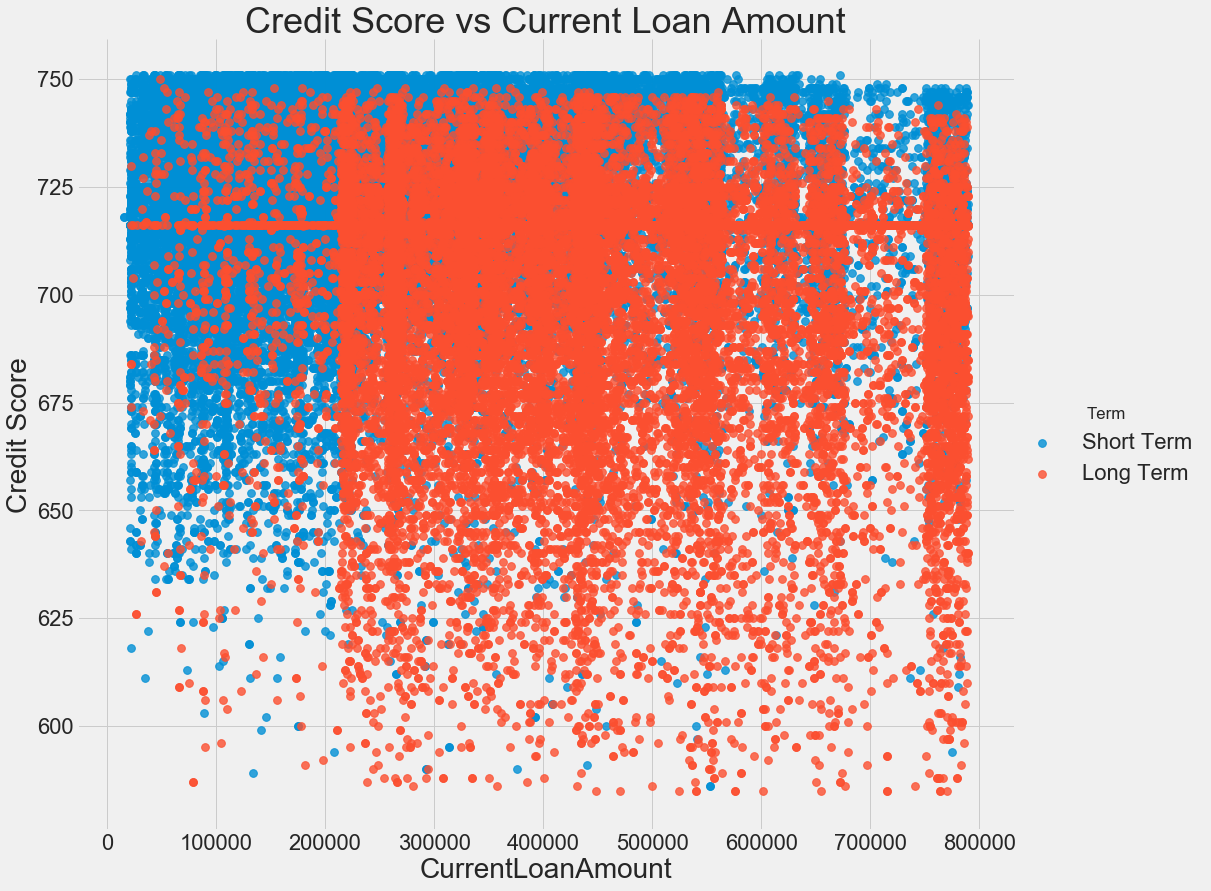

In [48]:
figsize = (12, 10)

# Extract the Term types

plot = raw_df[raw_df['CurrentLoanAmount'] < 1e07]
# Create a list of Term with more than 100 measurements to avoid clutter
types = raw_df
types = types['Term'].value_counts()
types = list(types[types.values > 200].index)
plot = plot[plot['Term'].isin(types)]


# Use seaborn to plot a scatterplot of Score vs Log Source EUI
sns.lmplot('CurrentLoanAmount', 'Credit Score', 
          hue = 'Term', data = plot,
          scatter_kws = {'alpha': 0.8, 's': 60}, fit_reg = False,
          size = 12, aspect = 1.2);

# Plot labeling
plt.xlabel("CurrentLoanAmount", size = 28)
plt.ylabel('Credit Score', size = 28)
plt.title('Credit Score vs Current Loan Amount', size = 36);

## Feature Selection and Feature Engineering

- Feature Engineering: The process of taking raw data and extracting or creating new features that allow a machine learning model to learn a mapping beween these features and the target. This might mean taking transformations of variables, such as we did with the log and square root, or one-hot encoding categorical variables so they can be used in a model. Generally, I think of feature engineering as adding additional features derived from the raw data.
- Feature Selection: The process of choosing the most relevant features in your data. "Most relevant" can depend on many factors, but it might be something as simple as the highest correlation with the target, or the features with the most variance. In feature selection, we remove features that do not help our model learn the relationship between features and the target. This can help the model generalize better to new data and results in a more interpretable model. Generally, I think of feature selection as subtracting features so we are left with only those that are most important.

Feature engineering and selection are iterative processes that will usually require several attempts to get right. Often we will use the results of modeling, such as the feature importances from a random forest, to go back and redo feature selection, or we might later discover relationships that necessitate creating new variables. Moreover, these processes usually incorporate a mixture of domain knowledge and statistical qualitites of the data.

In [49]:
## Remove multi-linearity 
### Features which are highly collinear due to some underlying similarity
### Hence keeping them is redundant 

def remove_collinear_features(x, threshold):
    '''
    Objective:
        Remove collinear features in a dataframe with a correlation coefficient
        greater than the threshold. Removing collinear features can help a model
        to generalize and improves the interpretability of the model.
        
    Inputs: 
        threshold: any features with correlations greater than this value are removed
    
    Output: 
        dataframe that contains only the non-highly-collinear features
    '''
    
    # Dont want to remove correlations between Credit Score
    y = x['Credit Score']
    x = x.drop(columns = ['Credit Score'])
    
    # Calculate the correlation matrix
    corr_matrix = x.corr()
    iters = range(len(corr_matrix.columns) - 1)
    drop_cols = []

    # Iterate through the correlation matrix and compare correlations
    for i in iters:
        for j in range(i):
            item = corr_matrix.iloc[j:(j+1), (i+1):(i+2)]
            col = item.columns
            row = item.index
            val = abs(item.values)
            
            # If correlation exceeds the threshold
            if val >= threshold:
                # Print the correlated features and the correlation value
                print(col.values[0], "|", row.values[0], "|", round(val[0][0], 2))
                drop_cols.append(col.values[0])

    # Drop one of each pair of correlated columns
    drops = set(drop_cols)
    feat = x.drop(columns = drops)
    
    # Add the score back in to the data
    feat['Credit Score'] = y
               
    return feat

In [54]:
features

,CurrentLoanAmount,Credit Score,Annual Income,Monthly Debt,Years of Credit History,Number of Open Accounts,Number of Credit Problems,Current Credit Balance,Maximum Open Credit,Bankruptcies,Tax Liens,sqrt_CurrentLoanAmount,log_CurrentLoanAmount,sqrt_Annual Income,log_Annual Income,sqrt_Monthly Debt,log_Monthly Debt,sqrt_Years of Credit History,log_Years of Credit History,sqrt_Number of Open Accounts,log_Number of Open Accounts,sqrt_Number of Credit Problems,log_Number of Credit Problems,sqrt_Current Credit Balance,log_Current Credit Balance,sqrt_Maximum Open Credit,log_Maximum Open Credit,sqrt_Bankruptcies,log_Bankruptcies,sqrt_Tax Liens,...,Years in current job_10+ years,Years in current job_2 years,Years in current job_3 years,Years in current job_4 years,Years in current job_5 years,Years in current job_6 years,Years in current job_7 years,Years in current job_8 years,Years in current job_9 years,Years in current job_< 1 year,Home Ownership_HaveMortgage,Home Ownership_Home Mortgage,Home Ownership_Own Home,Home Ownership_Rent,Purpose_Business Loan,Purpose_Buy House,Purpose_Buy a Car,Purpose_Debt Consolidation,Purpose_Educational Expenses,Purpose_Home Improvements,Purpose_Medical Bills,Purpose_Other,Purpose_Take a Trip,Purpose_major_purchase,Purpose_moving,Purpose_other,Purpose_renewable_energy,Purpose_small_business,Purpose_vacation,Purpose_wedding
0,445412,709.000000,1.167493e+06,5214.74,17.2,6,1,228190,416746.0,1.0,0.0,667.391939,13.006755,1080.505900,13.970369,72.213157,8.559245,4.147288,2.844909,2.449490,1.791759,1.0,0.0,477.692370,12.337934,645.558673,12.940232,1.0,0.0,0.0,...,0,0,0,0,0,0,0,1,0,0,0,1,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0
1,262328,716.277869,1.378189e+06,33295.98,21.1,35,0,229976,850784.0,0.0,0.0,512.179656,12.477351,1173.962781,14.136281,182.471861,10.413192,4.593474,3.049273,5.916080,3.555348,0.0,-inf,479.558130,12.345730,922.379531,13.653914,0.0,-inf,0.0,...,1,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0
2,99999999,741.000000,2.231892e+06,29200.53,14.9,18,1,297996,750090.0,0.0,0.0,9999.999950,18.420681,1493.951806,14.618360,170.881626,10.281942,3.860052,2.701361,4.242641,2.890372,1.0,0.0,545.890099,12.604835,866.077364,13.527948,0.0,-inf,0.0,...,0,0,0,0,0,0,0,1,0,0,0,0,1,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0
3,347666,721.000000,8.069490e+05,8741.90,12.0,9,0,256329,386958.0,0.0,0.0,589.632089,12.758998,898.303401,13.601016,93.498128,9.075883,3.464102,2.484907,3.000000,2.197225,0.0,-inf,506.289443,12.454217,622.059483,12.866071,0.0,-inf,0.0,...,0,0,1,0,0,0,0,0,0,0,0,0,1,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0
4,176220,716.277869,1.378189e+06,20639.70,6.1,15,0,253460,427174.0,0.0,0.0,419.785660,12.079488,1173.962781,14.136281,143.665236,9.934972,2.469818,1.808289,3.872983,2.708050,0.0,-inf,503.448111,12.442961,653.585496,12.964947,0.0,-inf,0.0,...,0,0,0,0,1,0,0,0,0,0,0,0,0,1,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0
5,206602,729.000000,8.968570e+05,16367.74,17.3,6,0,215308,272448.0,0.0,0.0,454.534927,12.238550,947.025343,13.706652,127.936469,9.703068,4.159327,2.850707,2.449490,1.791759,0.0,-inf,464.012931,12.279825,521.965516,12.515203,0.0,-inf,0.0,...,1,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0
6,217646,730.000000,1.184194e+06,10855.08,19.6,13,1,122170,272052.0,1.0,0.0,466.525455,12.290625,1088.206782,13.984573,104.187715,9.292388,4.427189,2.975530,3.605551,2.564949,1.0,0.0,349.528254,11.713169,521.586043,12.513749,1.0,0.0,0.0,...,0,0,0,0,0,0,0,0,0,1,0,1,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0
7,648714,716.277869,1.378189e+06,14806.13,8.2,15,0,193306,864204.0,0.0,0.0,805.427837,13.382747,1173.962781,14.136281,121.680442,9.602797,2.863564,2.104134,3.872983,2.708050,0.0,-inf,439.665782,12.172030,929.625731,13.669564,0.0,-inf,0.0,...,0,0,0,0,0,0,0,0,0,1,0,1,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0
8,548746,678.000000,2.559110e+06,18660.28,22.6,4,0,437171,555038.0,0.0,0.0,740.773920,13.215391,1599.721851,14.755170,136.602635,9.834152,4.753946,3.117950,2.000000,1.386294,0.0,-inf,661.189080,12.988080,745.008725,

In [56]:
feat = remove_collinear_features(features, 0.85)

sqrt_CurrentLoanAmount | CurrentLoanAmount | 1.0
log_CurrentLoanAmount | CurrentLoanAmount | 0.95
sqrt_Annual Income | Annual Income | 0.95
log_Annual Income | Annual Income | 0.86
sqrt_Monthly Debt | Monthly Debt | 0.97
log_Monthly Debt | Monthly Debt | 0.86
sqrt_Years of Credit History | Years of Credit History | 0.99
log_Years of Credit History | Years of Credit History | 0.96
sqrt_Number of Open Accounts | Number of Open Accounts | 0.99
log_Number of Open Accounts | Number of Open Accounts | 0.95
sqrt_Number of Credit Problems | Number of Credit Problems | 0.95
log_Number of Credit Problems | Number of Credit Problems | 0.95
sqrt_Current Credit Balance | Current Credit Balance | 0.88
sqrt_Bankruptcies | Bankruptcies | 0.98
log_Bankruptcies | Bankruptcies | 0.98
sqrt_Tax Liens | Tax Liens | 0.94
log_Tax Liens | Tax Liens | 0.93


C:\ProgramData\Anaconda3\envs\fastai_v1\lib\site-packages\ipykernel_launcher.py:37: RuntimeWarning: invalid value encountered in greater_equal


In [57]:
## Features with collinear ones removed
feat.head()

,CurrentLoanAmount,Annual Income,Monthly Debt,Years of Credit History,Number of Open Accounts,Number of Credit Problems,Current Credit Balance,Maximum Open Credit,Bankruptcies,Tax Liens,log_Current Credit Balance,sqrt_Maximum Open Credit,log_Maximum Open Credit,LoanStatus_Charged Off,LoanStatus_Fully Paid,Term_Long Term,Term_Short Term,Years in current job_1 year,Years in current job_10+ years,Years in current job_2 years,Years in current job_3 years,Years in current job_4 years,Years in current job_5 years,Years in current job_6 years,Years in current job_7 years,Years in current job_8 years,Years in current job_9 years,Years in current job_< 1 year,Home Ownership_HaveMortgage,Home Ownership_Home Mortgage,Home Ownership_Own Home,Home Ownership_Rent,Purpose_Business Loan,Purpose_Buy House,Purpose_Buy a Car,Purpose_Debt Consolidation,Purpose_Educational Expenses,Purpose_Home Improvements,Purpose_Medical Bills,Purpose_Other,Purpose_Take a Trip,Purpose_major_purchase,Purpose_moving,Purpose_other,Purpose_renewable_energy,Purpose_small_business,Purpose_vacation,Purpose_wedding,Credit Score
0,445412,1.167493e+06,5214.74,17.2,6,1,228190,416746.0,1.0,0.0,12.337934,645.558673,12.940232,0,1,0,1,0,0,0,0,0,0,0,0,1,0,0,0,1,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,709.000000
1,262328,1.378189e+06,33295.98,21.1,35,0,229976,850784.0,0.0,0.0,12.345730,922.379531,13.653914,0,1,0,1,0,1,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,716.277869
2,99999999,2.231892e+06,29200.53,14.9,18,1,297996,750090.0,0.0,0.0,12.604835,866.077364,13.527948,0,1,0,1,0,0,0,0,0,0,0,0,1,0,0,0,0,1,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,741.000000
3,347666,8.069490e+05,8741.90,12.0,9,0,256329,386958.0,0.0,0.0,12.454217,622.059483,12.866071,0,1,1,0,0,0,0,1,0,0,0,0,0,0,0,0,0,1,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,721.000000
4,176220,1.378189e+06,20639.70,6.1,15,0,253460,427174.0,0.0,0.0,12.442961,653.585496,12.964947,0,1,0,1,0,0,0,0,0,1,0,0,0,0,0,0,0,0,1,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,716.277869


In [58]:
feat.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 99280 entries, 0 to 99485
Data columns (total 49 columns):
CurrentLoanAmount                 99280 non-null int64
Annual Income                     99280 non-null float64
Monthly Debt                      99280 non-null float64
Years of Credit History           99280 non-null float64
Number of Open Accounts           99280 non-null int64
Number of Credit Problems         99280 non-null int64
Current Credit Balance            99280 non-null int64
Maximum Open Credit               99280 non-null float64
Bankruptcies                      99280 non-null float64
Tax Liens                         99280 non-null float64
log_Current Credit Balance        99280 non-null float64
sqrt_Maximum Open Credit          99280 non-null float64
log_Maximum Open Credit           99280 non-null float64
LoanStatus_Charged Off            99280 non-null uint8
LoanStatus_Fully Paid             99280 non-null uint8
Term_Long Term                    99280 non-null

## Split Into Training and Testing Sets

In [59]:
temp = feat

In [60]:
X = temp
y = raw_df['Credit Score']

In [61]:
X.head()

,CurrentLoanAmount,Annual Income,Monthly Debt,Years of Credit History,Number of Open Accounts,Number of Credit Problems,Current Credit Balance,Maximum Open Credit,Bankruptcies,Tax Liens,log_Current Credit Balance,sqrt_Maximum Open Credit,log_Maximum Open Credit,LoanStatus_Charged Off,LoanStatus_Fully Paid,Term_Long Term,Term_Short Term,Years in current job_1 year,Years in current job_10+ years,Years in current job_2 years,Years in current job_3 years,Years in current job_4 years,Years in current job_5 years,Years in current job_6 years,Years in current job_7 years,Years in current job_8 years,Years in current job_9 years,Years in current job_< 1 year,Home Ownership_HaveMortgage,Home Ownership_Home Mortgage,Home Ownership_Own Home,Home Ownership_Rent,Purpose_Business Loan,Purpose_Buy House,Purpose_Buy a Car,Purpose_Debt Consolidation,Purpose_Educational Expenses,Purpose_Home Improvements,Purpose_Medical Bills,Purpose_Other,Purpose_Take a Trip,Purpose_major_purchase,Purpose_moving,Purpose_other,Purpose_renewable_energy,Purpose_small_business,Purpose_vacation,Purpose_wedding,Credit Score
0,445412,1.167493e+06,5214.74,17.2,6,1,228190,416746.0,1.0,0.0,12.337934,645.558673,12.940232,0,1,0,1,0,0,0,0,0,0,0,0,1,0,0,0,1,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,709.000000
1,262328,1.378189e+06,33295.98,21.1,35,0,229976,850784.0,0.0,0.0,12.345730,922.379531,13.653914,0,1,0,1,0,1,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,716.277869
2,99999999,2.231892e+06,29200.53,14.9,18,1,297996,750090.0,0.0,0.0,12.604835,866.077364,13.527948,0,1,0,1,0,0,0,0,0,0,0,0,1,0,0,0,0,1,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,741.000000
3,347666,8.069490e+05,8741.90,12.0,9,0,256329,386958.0,0.0,0.0,12.454217,622.059483,12.866071,0,1,1,0,0,0,0,1,0,0,0,0,0,0,0,0,0,1,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,721.000000
4,176220,1.378189e+06,20639.70,6.1,15,0,253460,427174.0,0.0,0.0,12.442961,653.585496,12.964947,0,1,0,1,0,0,0,0,0,1,0,0,0,0,0,0,0,0,1,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,716.277869


In [62]:
# Replace the inf and -inf with nan (required for later imputation)
X = X.replace({np.inf: 0, -np.inf: 0, np.nan: 0})

In [69]:
X

,CurrentLoanAmount,Annual Income,Monthly Debt,Years of Credit History,Number of Open Accounts,Number of Credit Problems,Current Credit Balance,Maximum Open Credit,Bankruptcies,Tax Liens,log_Current Credit Balance,sqrt_Maximum Open Credit,log_Maximum Open Credit,LoanStatus_Charged Off,LoanStatus_Fully Paid,Term_Long Term,Term_Short Term,Years in current job_1 year,Years in current job_10+ years,Years in current job_2 years,Years in current job_3 years,Years in current job_4 years,Years in current job_5 years,Years in current job_6 years,Years in current job_7 years,Years in current job_8 years,Years in current job_9 years,Years in current job_< 1 year,Home Ownership_HaveMortgage,Home Ownership_Home Mortgage,Home Ownership_Own Home,Home Ownership_Rent,Purpose_Business Loan,Purpose_Buy House,Purpose_Buy a Car,Purpose_Debt Consolidation,Purpose_Educational Expenses,Purpose_Home Improvements,Purpose_Medical Bills,Purpose_Other,Purpose_Take a Trip,Purpose_major_purchase,Purpose_moving,Purpose_other,Purpose_renewable_energy,Purpose_small_business,Purpose_vacation,Purpose_wedding,Credit Score
15410,132506,9.918570e+05,15456.31,16.0,11,0,79724,183172.0,0.0,0.0,11.286326,427.985981,12.118181,1,0,0,1,0,0,0,0,0,1,0,0,0,0,0,0,0,0,1,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,728.000000
45155,668580,1.847712e+06,20632.86,23.4,10,0,424574,1022054.0,0.0,0.0,12.958842,1010.966864,13.837325,0,1,0,1,0,1,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,744.000000
78295,99999999,7.828380e+05,8024.08,26.0,5,1,79496,286770.0,1.0,0.0,11.283462,535.509104,12.566436,0,1,0,1,0,0,1,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,729.000000
80024,219648,7.364020e+05,11843.84,11.8,8,0,56639,388080.0,0.0,0.0,10.944453,622.960673,12.868967,1,0,0,1,0,0,0,1,0,0,0,0,0,0,0,0,0,0,1,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,723.000000
68125,99999999,1.037172e+06,24805.45,12.6,9,1,137180,216128.0,1.0,0.0,11.829049,464.895687,12.283626,0,1,0,1,0,1,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,640.000000
35694,398288,1.318600e+06,24943.58,14.7,11,0,466089,701822.0,0.0,0.0,13.052132,837.748172,13.461435,0,1,0,1,0,0,0,1,0,0,0,0,0,0,0,0,0,0,1,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,743.000000
4408,448294,9.737690e+05,5201.63,12.4,7,0,256956,749452.0,0.0,0.0,12.456660,865.708958,13.527098,0,1,0,1,0,1,0,0,0,0,0,0,0,0,0,0,0,1,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,736.000000
50704,178310,1.434044e+06,22538.37,19.0,8,1,85918,142758.0,1.0,0.0,11.361149,377.833297,11.868906,0,1,0,1,0,0,0,0,0,0,0,0,0,1,0,0,1,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,718.000000
66571,223366,1.296047e+06,4482.29,18.5,8,0,223820,342826.0,0.0,0.0,12.318597,585.513450,12.744978,0,1,0,1,0,0,0,0,1,0,0,0,0,0,0,0,1,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,703.000000
76694,99999999,1.815526e+06,34948.60,16.5,21,0,472815,665214.0,0.0,0.0,13.066459,815.606523,13.407864,0,1,0,1,0,1,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,708.000000


In [64]:
## Check Missing values now
missing_values_table(X)

Your selected dataframe has 49 columns.
There are 0 columns that have missing values.


,Missing Values,% of Total Values


In [65]:
# Split into 70% training and 30% testing set
X, X_test, y, y_test = train_test_split(X, y, test_size = 0.3, random_state = 42)

print(X.shape)
print(X_test.shape)
print(y.shape)
print(y_test.shape)

(69496, 49)
(29784, 49)
(69496,)
(29784,)


## Set Baseline
To compare against model
What is error of random guess

In [66]:
# Function to calculate mean absolute error
def mae(y_true, y_pred):
    return np.mean(abs(y_true - y_pred))

In [67]:
baseline_guess = np.median(y)

print('The baseline guess is a score of %0.2f' % baseline_guess)
print("Baseline Performance on the test set: MAE = %0.4f" % mae(y_test, baseline_guess))

The baseline guess is a score of 716.28
Baseline Performance on the test set: MAE = 17.5770


In [68]:
# Save the no scores, training, and testing data
X.to_csv('data/training_features_proc.csv', index = False)
X_test.to_csv('data/testing_features_proc.csv', index = False)
y.to_csv('data/training_labels_proc.csv', index = False)
y_test.to_csv('data/testing_labels_proc.csv', index = False)

C:\ProgramData\Anaconda3\envs\fastai_v1\lib\site-packages\ipykernel_launcher.py:4: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
  after removing the cwd from sys.path.
C:\ProgramData\Anaconda3\envs\fastai_v1\lib\site-packages\ipykernel_launcher.py:5: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
  """
